In [15]:
import numpy as np
t = np.array([1,2,3])
T = np.array([t])
T = np.append(T, t)
print(T)

[1 2 3 1 2 3]


## Preparing the target distribution of the MCMC Algorithms

Preparing the dataset of Gaussian Mixture Model with 2 components.  

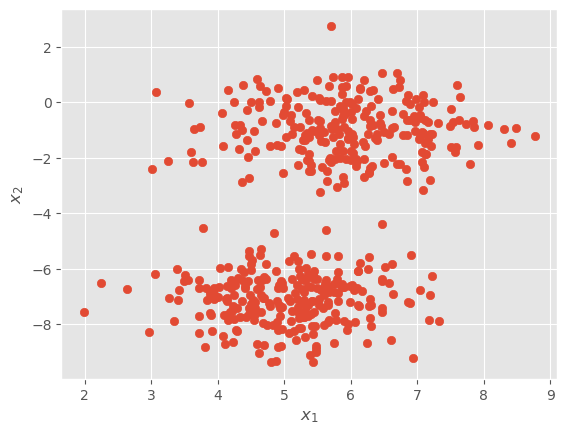

In [1]:
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.GMM_datagen import Data_params_gen_GMM
import matplotlib.pyplot as plt

GMM_data_2D_2com = Data_params_gen_GMM(n_components=2, n_dimensions=2)
_,_ = GMM_data_2D_2com.generate(datasize=500)

with plt.style.context("ggplot"):
    plt.scatter(GMM_data_2D_2com.noisy_Dataset[:, 0], GMM_data_2D_2com.noisy_Dataset[:, 1])
    plt.xlabel("$x_1$")

    plt.ylabel("$x_2$")
    plt.show()

Defining the Likelihood function with the dataset generated above.  

In [2]:
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.log_Likeli_GMM import Likeli_GMM_mus

GMM_Likeli_2D_2com = Likeli_GMM_mus(Dataset=GMM_data_2D_2com.noisy_Dataset, Sigmas=GMM_data_2D_2com.Sigmas, weights=GMM_data_2D_2com.weights, n_components=GMM_data_2D_2com.n_components)

## Apply the MCMC Algorithm

In [3]:
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.MHMC import MHMC
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.ProposalDistributions import  GaussianProposalDistribution
steps = 10000
Prop = GaussianProposalDistribution(sd=0.10, Dim=GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)
MHMC_GMM_2D_2com = MHMC(rho=GMM_Likeli_2D_2com.calculate_log_likelihoods, log_likelihood=True)
Res = MHMC_GMM_2D_2com.generate(
    theta0=[0 for _ in range(GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)], 
    qProb=Prop.qProb, 
    qSamp=Prop.qSample, 
    steps=steps
    )

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DianZhang/Dian_MCMC/MetropolisHastingMCMC/MHMC.py:80: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(self.rho(theta_1) + np.log(qProb(theta_1, theta_0)) - (self.rho(theta_0) + np.log(qProb(theta_0, theta_1)))))


## Visualize the output of the MCMC Algorithm

The acceptance rate of the MCMC algorithm = 0.194


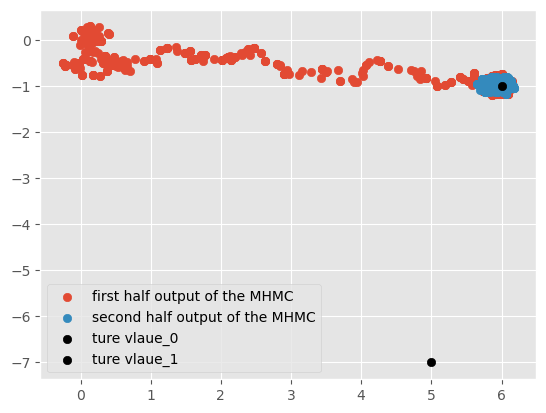

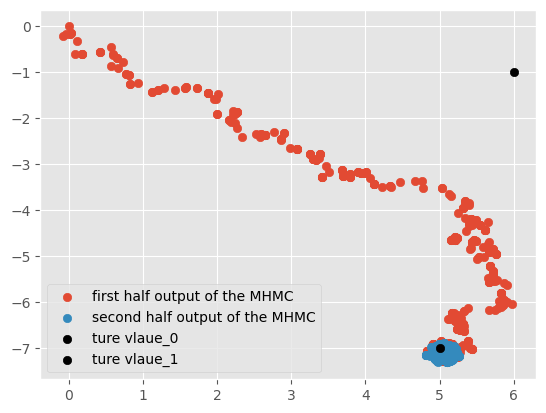

In [5]:
import numpy as np

print(f"The acceptance rate of the MCMC algorithm = {Res['Acceptance_Rate']:.3f}")
with plt.style.context("ggplot"):
    for i in range(GMM_Likeli_2D_2com.n_components):
        plt.scatter(Res["Thetas"][:steps//2, i*2], Res["Thetas"][:steps//2, i*2+1], label="first half output of the MHMC")
        plt.scatter(Res["Thetas"][steps//2:, i*2], Res["Thetas"][steps//2:, i*2+1], label="second half output of the MHMC")

        for j in range(GMM_Likeli_2D_2com.n_components):
            plt.scatter(GMM_data_2D_2com.mus[j][0], GMM_data_2D_2com.mus[j][1], label=f"ture vlaue_{j}", color="black")
        plt.legend()
        plt.show()

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DianZhang/Dian_MCMC/Statistic_tools.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


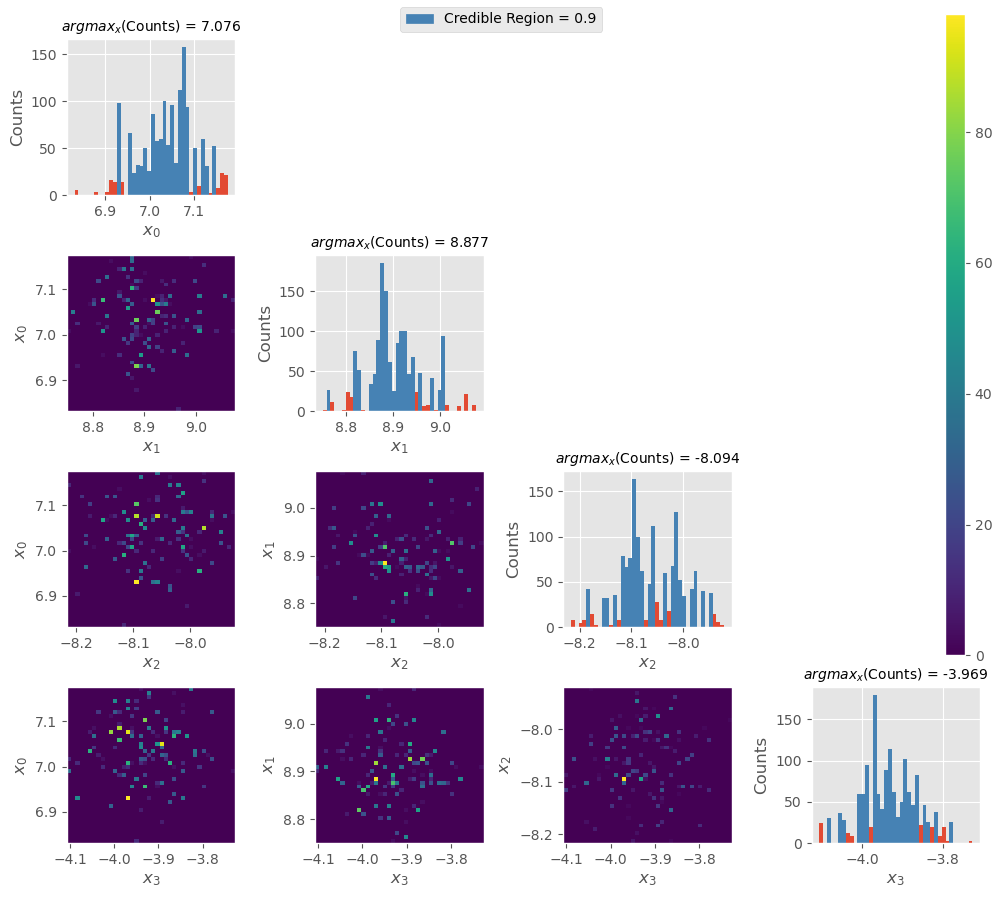

In [52]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import densities_plot

_ = densities_plot(Thetas=MCMC_outputs[2500:], plot_axis=[], bins=40, cr_1D=0.9)

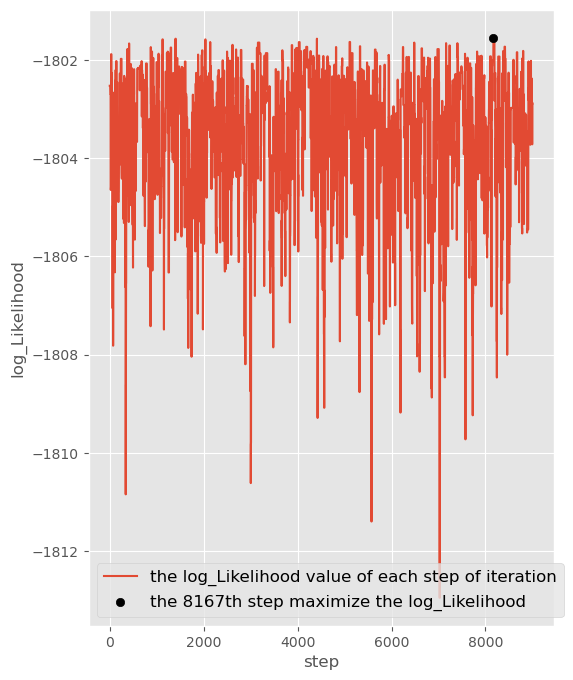

In [27]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import targetDis_step_plot
targetDis_step_plot(thetas=MCMC_outputs[1000:], rho=GMM_Likeli_2D_2com.calculate_log_likelihoods, target_type="log_Likelihood", return_maximum=True)

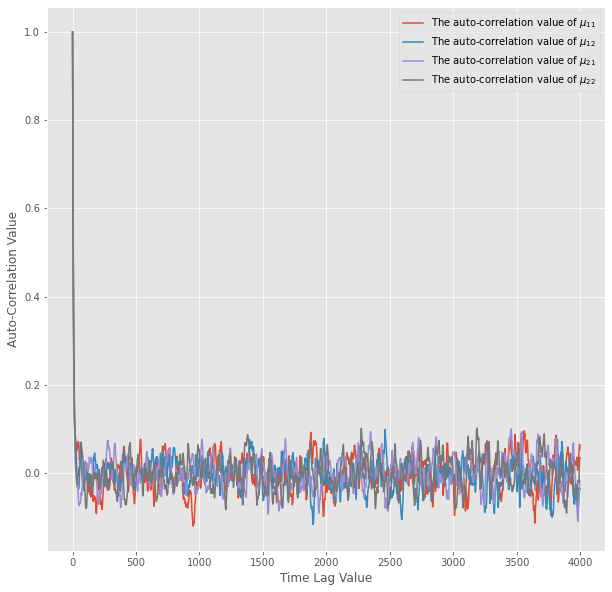

In [51]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import auto_corr_plot
auto_corr_plot(thetas=MCMC_outputs, plot_nth_theta=[0,1,2,3], theta_index=["$\mu_{11}$", "$\mu_{12}$", "$\mu_{21}$", "$\mu_{22}$"], max_time_lag=4000, data_range=[1999,9999])

In [11]:
print(f"The output of the MCMC method which maximize the log likelihood of the parameters is\n [{MCMC_outputs[1000+6319][:2]}, {MCMC_outputs[1000+6319][2:]}]")
print(f"The true value of the parameters is {GMM_data_2D_2com.mus}")

NameError: name 'MCMC_outputs' is not defined